# Introduction

First, we must ensure that the Watson Python SDK is installed and ready to use, we'll then import the SDK as well as the pandas library

**Note: Using `%%capture` just supresses the output, you can remove the line if you want to see the output from pip**

In [1]:
%%capture
!pip install watson_developer_cloud==1.5

In [2]:
from watson_developer_cloud import DiscoveryV1
import pandas as pd

# Initialize Watson Discovery

Now we'll initialize Watson Discovery using our login credentials. In order to obtain these, create a Watson Discovery services with your IBM Cloud account, and generate new credentials.

In [3]:
# Enter your own credentials below - be sure to wrap each inside of single quotation marks
credentials = {
    'DISCOVERY_USERNAME': 'YOUR SERVICE USERNAME HERE',
    'DISCOVERY_PASSWORD': 'YOUR SERVICE PASSWORD HERE'
}

In [4]:
discovery = DiscoveryV1(
    version='2018-08-01',
    username= credentials['DISCOVERY_USERNAME'],
    password= credentials['DISCOVERY_PASSWORD'])

# Creating the query

There are a few elements to querying Watson Discovery news, I'll break down each of the elements.

`environment_id`: `system` just denotes that we're using the system environment

`collection_id`: We want to query the news collection

`query`: Basically we will be using a filter in order to isolate the articles that we want, so a query is not neccesary in this case

`offset`: The number of results (documents) to skip

`count`: The number of results (documents) to return 

***note: Count and offset is the way pagination of results is implemented, the maximum of total results (offset + count) cannot exceed 1,000***

`deduplicate`: This is a beta feature to have Watson remove duplicate articles

`aggregation`: This is a analytic query of the results set - in this case, the entire collection of news articles, filtered by Company (in this case 'bitcoin' is the company in question)

`filter`: The query for matching documents

`return_fields`: What items to actually return to us for our use

**For more information, check out the [query reference](https://cloud.ibm.com/docs/services/discovery/query-reference.html#query-reference)**


We are using DEFAULT_COUNT of 50, the maximum you can query at once, and incrementing until we've captured all available documents or hit 1,000 (the maximum).

In [5]:
all_results = []

DEFAULT_COUNT = 50
offset = 0

while offset + DEFAULT_COUNT <= 1000:
    try:
        result = discovery.query(environment_id='system',
                                 collection_id='news-en',
                                 query='',
                                 offset=offset,
                                 count=DEFAULT_COUNT,
                                 deduplicate=True,
                                 aggregation='filter(enriched_title.entities.type::Company).term(enriched_title.entities.text).timeslice(crawl_date,1day).term(enriched_text.sentiment.document.score)',
                                 filter='Bitcoin',
                                 return_fields=['publication_date', 'enriched_text.sentiment.document'])
        
        # If the results are empty, stop querying
        if not result['results']:
            break
        
        # Add results to all_results and increment offset
        all_results.extend(result['results'])
        
        offset += offset + DEFAULT_COUNT
    except:
        break

# Using the data

Now that we've queried Watson Discovery, we need to make the data usable. What is returned is an object with a few different fields, the one we're concerned with though is `results` (the items we asked for in `return_fields` of the query will be here). After each query in the previous `while` loop, we added the `result['results']` to an array of all results. Now we'll work with them.

First we'll create a pandas dataframe, think of it as putting the data into a spreadsheet. Then we'll iterate over the array of results, and add them to our new dataframe.

In [6]:
df = pd.DataFrame()

In [7]:
_date = []
_sentiment_label = []
_sentiment_score = []

for r in all_results:
    _date.append(r['publication_date'])
    _sentiment_label.append(r['enriched_text']['sentiment']['document']['label'])
    _sentiment_score.append(r['enriched_text']['sentiment']['document']['score'])

In [8]:
df['publication_date'] = _date
df['sentiment_label'] = _sentiment_label
df['sentiment_score'] = _sentiment_score
df.index = df['publication_date']

In [9]:
df['publication_date'] = pd.to_datetime(df['publication_date'])
df.index = df['publication_date']

# Looking at the data

When we call the  `df.head()` function, we can visually see the first portion of our data - remember the concept of a spreadsheet? Here we can see how the sentiment label coorelates to the score. Sentinent scores range from negative to positive, -1 to 1, with 0 being neutral. Watson has just taken the leg work away from assigning a label, but you could easily do this yourself as well.

In [10]:
df.head()

,publication_date,sentiment_label,sentiment_score
publication_date,,,
2018-09-23 12:34:00,2018-09-23 12:34:00,negative,-0.029183
2018-09-23 11:46:00,2018-09-23 11:46:00,negative,-0.560177
2018-09-23 12:42:00,2018-09-23 12:42:00,negative,-0.022305
2018-09-23 10:00:00,2018-09-23 10:00:00,negative,-0.368113
2018-09-23 12:42:00,2018-09-23 12:42:00,negative,-0.167054


# Visualizing the data

Now that we've set up our dataframe, we can use `matplotlib` to visualize a portion of the data. In this example, we're using the sentiment label (negative, positive, neutral), and visualize the data in a pie chart.

First we import `matplotlib.pyplot`, and just for aesthetics, set the style to use `fivethirtyeight` (as an aside, if you call `matplotlib.style.available`, you can see a full list of styles available. You could also not set the style and use the default as well).

Finally, the column we want to analyze we previously named `sentimnent`, we access the column with `df['sentiment']`, we then call the helper function `value_counts()` to get a count of each sentiment lable, and then finally use the `plot()` method to plot the data in a pie chart.

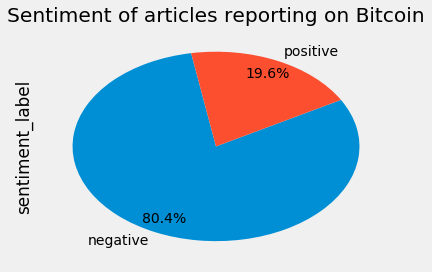

In [12]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

df['sentiment_label'].value_counts().plot(kind='pie', 
                                    subplots=False, 
                                    startangle=100,
                                    pctdistance=0.85,
                                    autopct='%1.1f%%',
                                    title='Sentiment of articles reporting on Bitcoin')

# center_circle = plt.Circle((0,0),0.70,fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(center_circle)

plt.tight_layout()
plt.show()